In [72]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from yahoo_fin import stock_info

In [116]:
tcsdaily = stock_info.get_data("TCS.NS", interval="1wk")
tcsdaily = tcsdaily.drop(['ticker'], axis=1)
tcsdaily=tcsdaily.dropna()
tcsdaily

,open,high,low,close,adjclose,volume
2002-08-11,38.724998,40.387501,35.724998,36.375000,26.099277,2001184.0
2002-08-18,36.674999,43.625000,35.137501,42.299999,30.350513,18564720.0
2002-08-25,42.974998,45.125000,40.287498,44.049999,31.606138,12945024.0
2002-09-01,44.750000,45.974998,41.012501,41.474998,29.758575,6795040.0
2002-09-08,39.500000,43.224998,39.500000,40.987499,29.408792,2637016.0
...,...,...,...,...,...,...
2023-02-19,3502.000000,3522.000000,3382.300049,3400.449951,3400.449951,6073215.0
2023-02-26,3390.000000,3392.000000,3299.899902,3342.149902,3342.149902,9513274.0
2023-03-05,3361.899902,3404.949951,3290.000000,3331.000000,3331.000000,5851626.0
2023-03-12,3333.000000,3369.800049,3144.000000,3179.300049,3179.300049,14993115.0


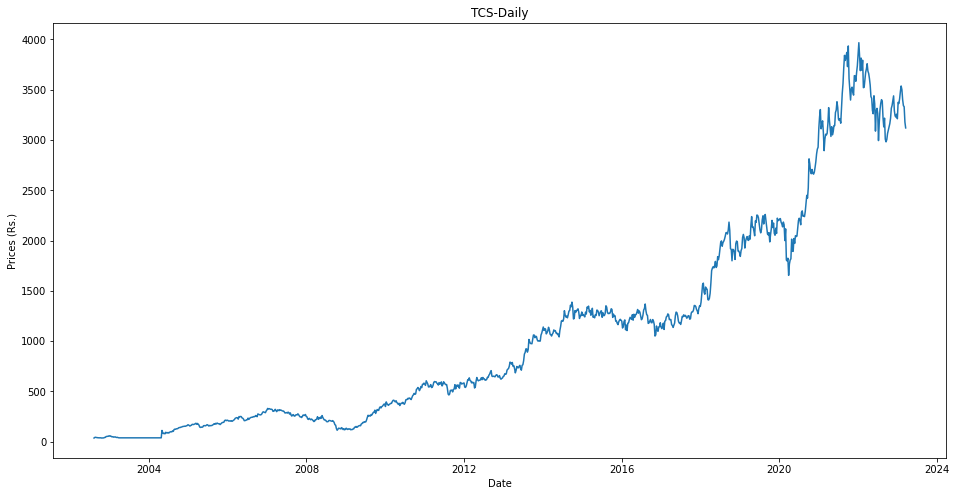

In [117]:
plt.figure(figsize=(16,8))
plt.plot(tcsdaily['close'])
plt.title('TCS-Daily')
plt.xlabel('Date')
plt.ylabel('Prices (Rs.)')
plt.show()

In [118]:
#Take close prices
close_prices = tcsdaily['close'] 
close_prices

2002-08-11      36.375000
2002-08-18      42.299999
2002-08-25      44.049999
2002-09-01      41.474998
2002-09-08      40.987499
                 ...     
2023-02-19    3400.449951
2023-02-26    3342.149902
2023-03-05    3331.000000
2023-03-12    3179.300049
2023-03-19    3120.500000
Name: close, Length: 1076, dtype: float64

In [119]:
#take only values of close prices
values = close_prices.values 
print(len(values))
values[0:10]

1076


array([36.375     , 42.29999924, 44.04999924, 41.47499847, 40.98749924,
       39.09999847, 38.47499847, 37.51250076, 38.21250153, 38.8125    ])

In [120]:
#take 80% of the data for training
training_data_len = math.ceil(len(values)* 0.8) 
training_data_len

861

In [121]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

#Select training data from 0 to length
train_data = scaled_data[0: training_data_len, :]

#Print
print(len(train_data))
print(train_data[0])
print(train_data[1])
print(min(train_data))
print(max(train_data))
scaled_data[0:10]

861
[0.]
[0.00150695]
[0.]
[0.54614646]


array([[0.        ],
       [0.00150695],
       [0.00195204],
       [0.00129712],
       [0.00117313],
       [0.00069307],
       [0.00053411],
       [0.00028931],
       [0.00046735],
       [0.00061995]])

In [122]:
x_train = []
y_train = []

#Create a list of 60 values in a single input in x_train and then the take the 61st value in y such as to 
#predict it
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #Take 60 values and put in 1st
    y_train.append(train_data[i, 0]) #Take 61st value and put in it's 
    

x_train, y_train = np.array(x_train), np.array(y_train)

#Print check some stuff
print(len(x_train))
print(len(y_train))
print(len(x_train[0]))
print(len(x_train[1]))
print(y_train[0])
print(x_train[0][0:10])

801
801
60
60
0.0005118555392730623
[0.         0.00150695 0.00195204 0.00129712 0.00117313 0.00069307
 0.00053411 0.00028931 0.00046735 0.00061995]


In [123]:
#Reshape the values
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Print
print(len(x_train))
x_train[0][0:10]

801


array([[0.        ],
       [0.00150695],
       [0.00195204],
       [0.00129712],
       [0.00117313],
       [0.00069307],
       [0.00053411],
       [0.00028931],
       [0.00046735],
       [0.00061995]])

In [124]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 25)                2525      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 50, epochs=10)

Epoch 1/10
17/17 [==============================] - 7s 129ms/step - loss: 0.0066
Epoch 2/10
17/17 [==============================] - 3s 166ms/step - loss: 4.2756e-04
Epoch 3/10
17/17 [==============================] - 3s 156ms/step - loss: 2.5148e-04
Epoch 4/10
17/17 [==============================] - 2s 130ms/step - loss: 2.5212e-04
Epoch 5/10
17/17 [==============================] - 2s 129ms/step - loss: 1.9057e-04
Epoch 6/10
17/17 [==============================] - 2s 132ms/step - loss: 1.9305e-04
Epoch 7/10
17/17 [==============================] - 2s 133ms/step - loss: 1.8144e-04
Epoch 8/10
17/17 [==============================] - 3s 148ms/step - loss: 1.9155e-04
Epoch 9/10
17/17 [==============================] - 2s 141ms/step - loss: 1.8338e-04
Epoch 10/10
17/17 [==============================] - 3s 164ms/step - loss: 2.5086e-04


In [133]:
test_data = scaled_data[training_data_len-60: , : ]

x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(len(x_test))
print(len(y_test))

215
215


In [130]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print(len(predictions))
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 [==============================] - 0s 43ms/step
215


37.04931867732558

/var/folders/_m/7wdfvnkn1871d5q_fgf9lqj00000gn/T/ipykernel_10857/2595987141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


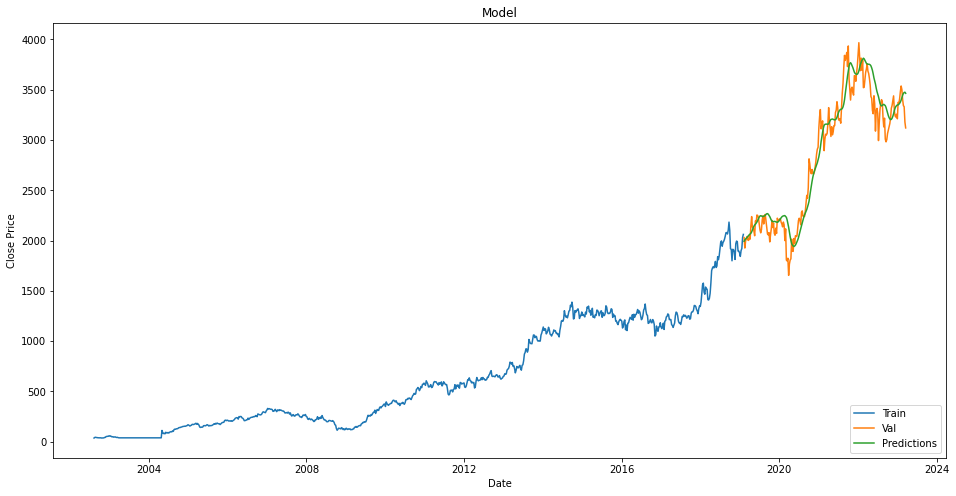

In [131]:
data1 = tcsdaily.filter(['close'])
train = data1[:training_data_len]
validation = data1[training_data_len:]
validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()